In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("default")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

file_path = "cpsc370 final data.xlsx"
sheet1 = pd.read_excel(file_path, sheet_name="Sheet1")

sheet1.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,eGRID Data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2012.0,2014.0,2016.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
3,NaN,CAMX,619.9,568.6,527.9,496.5,453.2,513.5,513.7,497.4,428.5
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:

years_egrid = (
    sheet1.iloc[2, 2:]
    .dropna()
    .astype(int)
    .tolist()
)

regions_keep = ["CAMX", "NWPP", "ERCT", "RFCW", "SRVC", "NYUP"]

egrid_regions = sheet1[sheet1["Unnamed: 1"].isin(regions_keep)].copy()

egrid_regions = egrid_regions.drop(columns=["Unnamed: 0"])
egrid_regions.columns = ["region"] + years_egrid

print(egrid_regions)

   region    2012    2014    2016    2018    2019   2020    2021    2022  \
3    CAMX   619.9   568.6   527.9   496.5   453.2  513.5   513.7   497.4   
5    NWPP   915.7   907.0   651.2   639.0   715.2  600.0   634.6   602.1   
7    ERCT  1103.2  1142.8  1009.2   931.7   868.6  818.6   813.6   771.1   
9    RFCW  1497.1  1380.8  1243.4  1166.1  1067.7  985.0  1046.1  1000.1   
11   SRVC   862.3   856.6   805.3   743.3   675.4  623.1   639.7   623.0   
13   NYUP   377.2   365.7   294.7   253.1   232.3  233.5   233.1   274.6   

     2023  
3   428.5  
5   631.7  
7   733.9  
9   911.4  
11  593.4  
13  242.1  


In [8]:
egrid_long = egrid_regions.melt(
    id_vars="region",
    var_name="year",
    value_name="co2_lb_per_MWh"
)
egrid_long["year"] = egrid_long["year"].astype(int)

egrid_long.head()

,region,year,co2_lb_per_MWh
0,CAMX,2012,619.9
1,NWPP,2012,915.7
2,ERCT,2012,1103.2
3,RFCW,2012,1497.1
4,SRVC,2012,862.3


#Temporal analysis: CO2 intensity over time

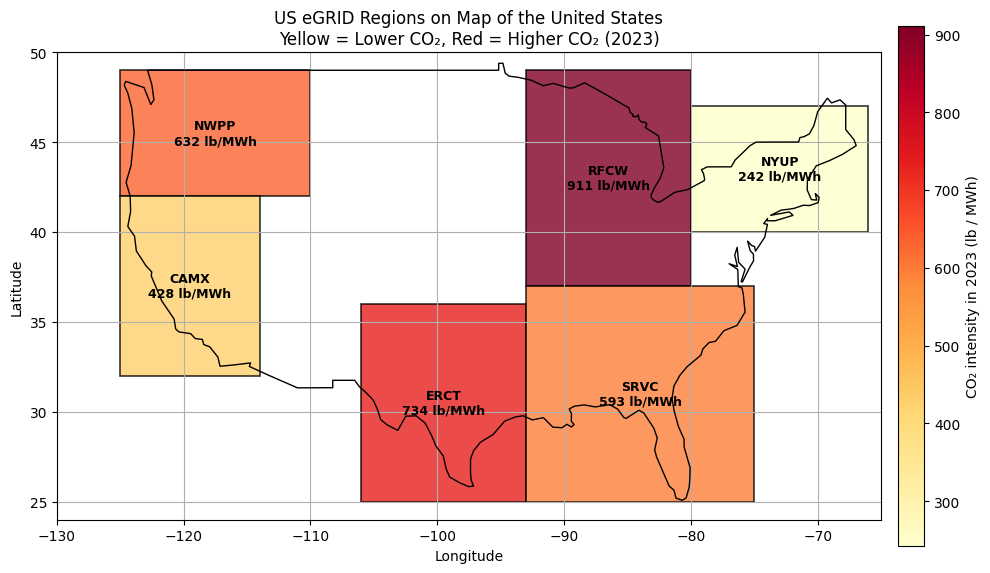

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import numpy as np

latest = (
    egrid_long[egrid_long["year"] == 2023]
    .set_index("region")["co2_lb_per_MWh"]
)

world_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_url)
usa = world[world["ADMIN"] == "United States of America"]

region_boxes_ll = {
    "NWPP": (-125, 42, -110, 49),  # Pacific Northwest
    "CAMX": (-125, 32, -114, 42),  # California
    "ERCT": (-106, 25, -93, 36),   # Texas / ERCOT
    "RFCW": (-93, 37, -80, 49),    # Midwest / Rust Belt
    "SRVC": (-93, 25, -75, 37),    # Southeast / Mid-Atlantic
    "NYUP": (-80, 40, -66, 47),    # Northeast / Upstate NY
}

cmap = plt.cm.YlOrRd
norm = mcolors.Normalize(vmin=latest.min(), vmax=latest.max())

fig, ax = plt.subplots(figsize=(10, 6))


usa.boundary.plot(ax=ax, linewidth=1, color="black")


for region, (west, south, east, north) in region_boxes_ll.items():
    value = latest.get(region, np.nan)
    color = cmap(norm(value)) if not np.isnan(value) else "lightgrey"

    width = east - west
    height = north - south

    rect = patches.Rectangle(
        (west, south),
        width, height,
        linewidth=1.2,
        edgecolor="black",
        facecolor=color,
        alpha=0.8
    )
    ax.add_patch(rect)


    ax.text(
        west + width / 2,
        south + height / 2,
        f"{region}\n{value:.0f} lb/MWh",
        ha="center",
        va="center",
        fontsize=9,
        fontweight="bold",
    )

ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("CO₂ intensity in 2023 (lb / MWh)")

plt.title("US eGRID Regions on Map of the United States\nYellow = Lower CO₂, Red = Higher CO₂ (2023)")
plt.tight_layout()
plt.show()

#% change from 2012 - 2023 (for each region)

In [10]:
baseline = (
    egrid_long[egrid_long["year"] == 2012]
    .set_index("region")["co2_lb_per_MWh"]
)
latest = (
    egrid_long[egrid_long["year"] == 2023]
    .set_index("region")["co2_lb_per_MWh"]
)

percent_change = ((latest - baseline) / baseline * 100).round(1)

summary_table = pd.DataFrame({
    "2012_CO2_lb_per_MWh": baseline,
    "2023_CO2_lb_per_MWh": latest,
    "Percent_change_2012_to_2023": percent_change
})

summary_table

,2012_CO2_lb_per_MWh,2023_CO2_lb_per_MWh,Percent_change_2012_to_2023
region,,,
CAMX,619.9,428.5,-30.9
NWPP,915.7,631.7,-31.0
ERCT,1103.2,733.9,-33.5
RFCW,1497.1,911.4,-39.1
SRVC,862.3,593.4,-31.2
NYUP,377.2,242.1,-35.8


#Spatial snapshot: which regions are dirtiest in 2023?

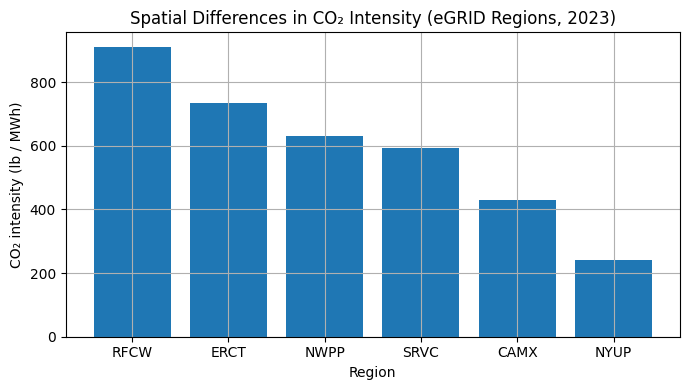

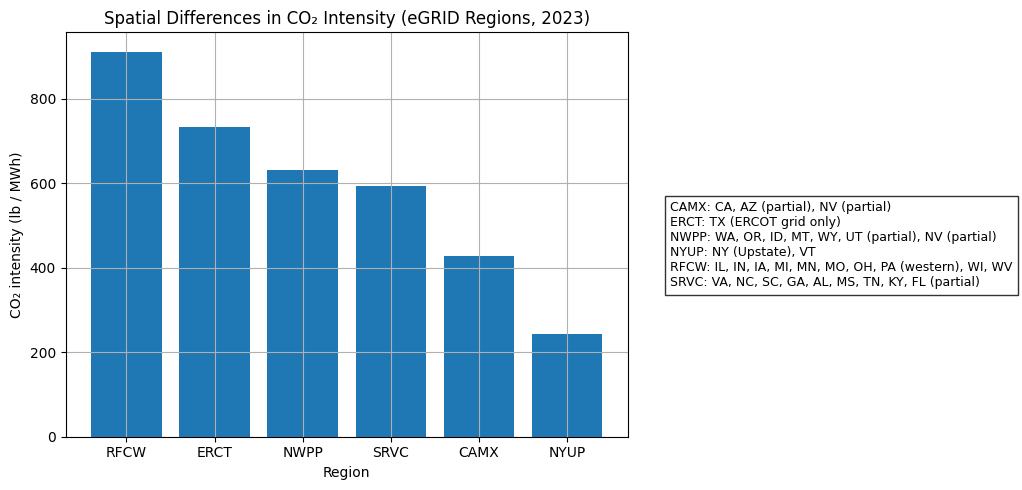

In [12]:
egrid_2023 = (
    egrid_long[egrid_long["year"] == 2023]
    .sort_values("co2_lb_per_MWh", ascending=False)
)

plt.figure(figsize=(7, 4))
plt.bar(egrid_2023["region"], egrid_2023["co2_lb_per_MWh"])
plt.title("Spatial Differences in CO₂ Intensity (eGRID Regions, 2023)")
plt.xlabel("Region")
plt.ylabel("CO₂ intensity (lb / MWh)")
plt.tight_layout()
plt.show()

egrid_2023

region_states = {
    "CAMX": ["CA", "AZ (partial)", "NV (partial)"],
    "ERCT": ["TX (ERCOT grid only)"],
    "NWPP": ["WA", "OR", "ID", "MT", "WY", "UT (partial)", "NV (partial)"],
    "NYUP": ["NY (Upstate)", "VT"],
    "RFCW": ["IL", "IN", "IA", "MI", "MN", "MO", "OH", "PA (western)", "WI", "WV"],
    "SRVC": ["VA", "NC", "SC", "GA", "AL", "MS", "TN", "KY", "FL (partial)"]
}

region_states_df = pd.DataFrame([
    {"Region": region, "States Included": ", ".join(states)}
    for region, states in region_states.items()
])

region_states_df
plt.figure(figsize=(9, 5))
plt.bar(egrid_2023["region"], egrid_2023["co2_lb_per_MWh"])
plt.title("Spatial Differences in CO₂ Intensity (eGRID Regions, 2023)")
plt.xlabel("Region")
plt.ylabel("CO₂ intensity (lb / MWh)")

key_text = "\n".join([
    f"{region}: {', '.join(states)}"
    for region, states in region_states.items()
])

plt.gcf().text(
    0.75, 0.5, key_text,
    fontsize=9,
    va="center", ha="left",
    bbox=dict(facecolor="white", edgecolor="black", alpha=0.8)
)

plt.tight_layout(rect=[0, 0, 0.72, 1])  # Make space for key
plt.show()

#Read AI / data-center electricity data

In [13]:
years_ai = (
    sheet1.iloc[19, 2:]
    .dropna()
    .astype(int)
    .tolist()
)

vals_ai = sheet1.iloc[20, 2:2+len(years_ai)].tolist()

ai_energy = pd.DataFrame({
    "year": years_ai,
    "dc_twh": vals_ai
})

ai_energy

,year,dc_twh
0,2020,269.0
1,2023,361.0
2,2024,416.0
3,2030,946.0


#AI/Data Center Electricity Growth

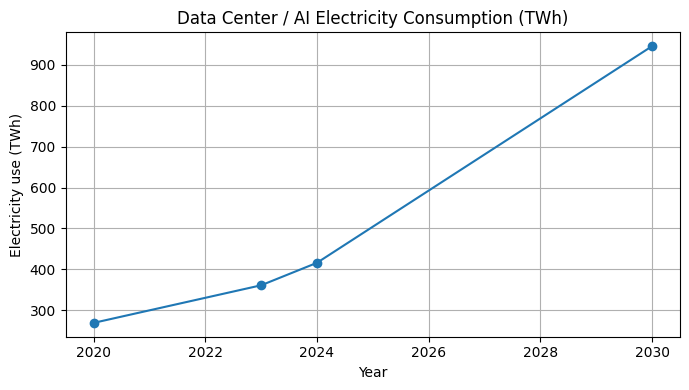

In [14]:
plt.figure(figsize=(7, 4))
plt.plot(ai_energy["year"], ai_energy["dc_twh"], marker="o")
plt.title("Data Center / AI Electricity Consumption (TWh)")
plt.xlabel("Year")
plt.ylabel("Electricity use (TWh)")
plt.tight_layout()
plt.show()

In [15]:
avg_intensity = (
    egrid_long.groupby("year")["co2_lb_per_MWh"]
    .mean()
    .reset_index(name="avg_co2_lb_per_MWh")
)

avg_intensity

,year,avg_co2_lb_per_MWh
0,2012,895.900000
1,2014,870.250000
2,2016,755.283333
3,2018,704.950000
4,2019,668.733333
5,2020,628.950000
6,2021,646.800000
7,2022,628.050000
8,2023,590.166667


In [16]:
combined = pd.merge(ai_energy, avg_intensity, on="year", how="left")


combined_valid = combined.dropna(subset=["avg_co2_lb_per_MWh"]).copy()

combined_valid["est_co2_kg"] = (
    combined_valid["dc_twh"] * 1_000_000
    * combined_valid["avg_co2_lb_per_MWh"]
    * 0.453592
)

combined_valid["est_co2_Mt"] = combined_valid["est_co2_kg"] / 1e9

combined_valid

,year,dc_twh,avg_co2_lb_per_MWh,est_co2_kg,est_co2_Mt
0,2020,269.0,628.950000,7.674212e+10,76.742119
1,2023,361.0,590.166667,9.663785e+10,96.637851


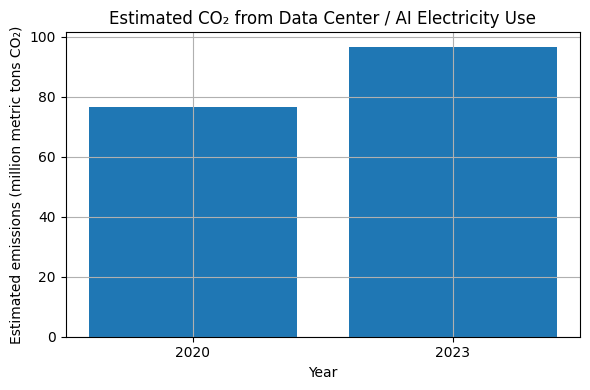

In [17]:
plt.figure(figsize=(6, 4))
plt.bar(
    combined_valid["year"].astype(str),
    combined_valid["est_co2_Mt"]
)
plt.title("Estimated CO₂ from Data Center / AI Electricity Use")
plt.xlabel("Year")
plt.ylabel("Estimated emissions (million metric tons CO₂)")
plt.tight_layout()
plt.show()

In [18]:
!pip install geopandas shapely fiona pyproj rtree
import geopandas as gpd

subregions = gpd.read_file("/content/eGRID2023_Subregions.shp")
print(subregions.head())

import pandas as pd

egrid_long = pd.read_csv("cpsc370 final data.xlsx")
print(egrid_long.head())

egrid_2023 = (
    egrid_long[egrid_long["year"] == 2023]
    .sort_values("co2_lb_per_MWh", ascending=False)
)

merged = subregions.merge(
    egrid_2023,
    left_on="SUBRGN",
    right_on="region",
    how="left"
)

merged.plot(column="co2_lb_per_MWh", legend=True, cmap="Reds", edgecolor="black")
plt.title("CO₂ Intensity by eGRID Subregion (2023)")
plt.show()



DataSourceError: /content/eGRID2023_Subregions.shp: No such file or directory